Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [3]:
# Import all the goods
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

# Wrangle the data
'''
I think I've made this wrangling function enough times this week to not annotate
everyline of it anymore, so I'll just annotate important stuff this time,
to stay in good practice.
'''
def wrangle(X):
    X = X.copy()
    # deal with weird latitudes, then replace all 0s with nans for later imputing
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    cols_with_zeros = ['longitude', 'latitude', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
    # drop duplicates
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    # Drop recorded_by and id(add no usable info)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    # Deal with dates
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    # engineer a couple features
    X['pump_age'] = X['year_recorded'] - X['construction_year']
    X['water/person'] = X['amount_tsh'] / X['population']
    return X

# split the data so i can wrangle it all
train, val = train_test_split(train, train_size=.80, test_size=.20,
                             stratify=train['status_group'], random_state=42)

# wrangle it all
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [10]:
# define features and target
target = 'status_group'
features = train.columns.drop(target)

# define my vectors and matrices
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]


In [8]:
# Import randint/uniform and RandomizedsearchCV(forgot to earlier, thought i had everything!)
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

# make my pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)

'''
Im going to run the parameter distributions and a larger randomizedsearch 
than i used yesterday even though its not required because i really want
to increase my spot on the leaderboard
'''
# pipeline parameters
param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': range(5, 30, 5), 
    'randomforestclassifier__max_features': uniform(0, 1),
}
# instantiate randomizedsearchcv
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=5, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

#run my search
search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed: 31.6min remaining:  6.9min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed: 36.1min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 41.4min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            f

In [11]:
search.score(X_val, y_val)
# Still didnt improve my score which is super disappointing!

0.8095117845117845

In [12]:
# Confusion matrix, aka the whole requirement for the assignment :O
# define my y_pred
y_pred = search.predict(X_val)

#import the matrix
from sklearn.metrics import confusion_matrix

# create the matrix
confusion_matrix(y_val, y_pred)

array([[5754,  158,  540],
       [ 456,  259,  148],
       [ 899,   62, 3604]], dtype=int64)

In [13]:
# Now lets spruce it up and make it look purtier
# import what ill need
from sklearn.utils.multiclass import unique_labels
import seaborn as sns

# this is me replicating the lesson code to get the heatmap
def plot_confusion_heatmap(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

'''
But honestly i prefer a simple table, its easier to look at for me,
im a numbers guy more than a visuals guy. So heres my function for one
'''

def confusion_table(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return table


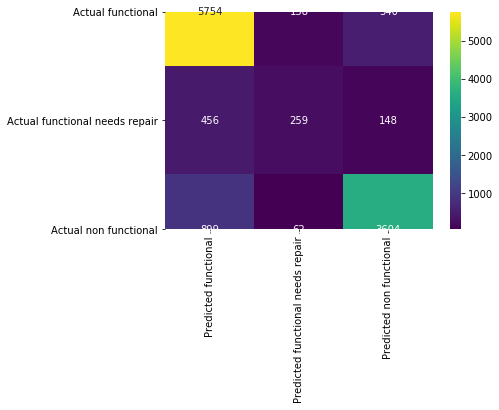

In [14]:
plot_confusion_heatmap(y_val, y_pred)

In [15]:
confusion_table(y_val, y_pred)

,Predicted functional,Predicted functional needs repair,Predicted non functional
Actual functional,5754,158,540
Actual functional needs repair,456,259,148
Actual non functional,899,62,3604
